In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

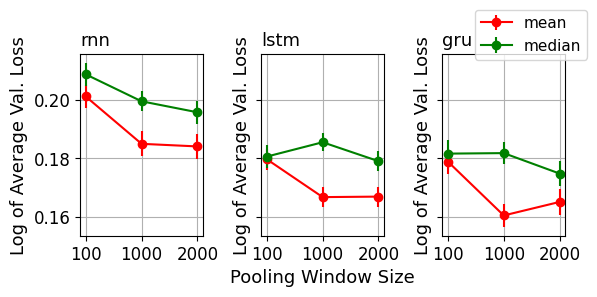

In [7]:
# %%
loss_type = 'square'

# Create a single figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(6, 3), sharey=True)

# Plot the data for each model
for i, model in enumerate(['rnn', 'lstm', 'gru']):
    stat_df = pd.read_csv(f"../model/{model}/stat.csv")
    stat_df = stat_df[stat_df['loss_type'] == loss_type]
    stat_compress_df = stat_df.groupby(['compress_type', 'compress_size']).agg(
        val_loss_mean=('val_loss', 'mean'),
        val_loss_std=('val_loss', 'std')
    ).reset_index()
    stat_compress_df['compress_size'] = stat_compress_df['compress_size'].astype(str)
    
    # Apply log transformation to val_loss mean
    stat_compress_df['log_val_loss'] = np.log10(stat_compress_df['val_loss_mean'])
    
    # Calculate log-transformed error bounds (± std dev with a scaling factor of 0.1)
    stat_compress_df['log_val_loss_lower'] = np.log10(stat_compress_df['val_loss_mean'] - 0.1 * np.log10(stat_compress_df['val_loss_std']))
    stat_compress_df['log_val_loss_upper'] = np.log10(stat_compress_df['val_loss_mean'] + 0.1 * np.log10(stat_compress_df['val_loss_std']))

    # Use blue and orange colors for the plots
    palette = sns.color_palette(["red", "green"], n_colors=len(stat_compress_df['compress_type'].unique()))

    # Plot on the i-th axis (subplot), disable the legend for each individual plot
    for idx, compress_type in enumerate(stat_compress_df['compress_type'].unique()):
        compress_data = stat_compress_df[stat_compress_df['compress_type'] == compress_type]
        axes[i].errorbar(
            compress_data['compress_size'], 
            compress_data['log_val_loss'], 
            yerr=[
                compress_data['log_val_loss'] - compress_data['log_val_loss_lower'],
                compress_data['log_val_loss_upper'] - compress_data['log_val_loss']
            ], 
            fmt='-o', color=palette[idx], label=compress_type
        )

    # Add labels and title for each subplot
    if i == 1:
        axes[i].set_xlabel("Pooling Window Size", fontsize=13)
    else:
        axes[i].set_xlabel("")
    axes[i].set_ylabel("Log of Average Val. Loss", fontsize=13)
    axes[i].set_title(f"{model}", loc='left', fontsize=13)
    axes[i].grid(True)
    axes[i].tick_params(axis='x', labelsize=12)  # Increase x-axis tick label size
    axes[i].tick_params(axis='y', labelsize=12)  # Increase y-axis tick label size

# Instead of creating handles manually, we use the first plot to generate the legend
handles, labels = axes[0].get_legend_handles_labels()

# Add the global legend at the top center of the figure
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.00, 1), ncol=1, fontsize=11)

# Adjust layout and ensure the legend doesn't overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the space needed for the legend

# Save the plot
plt.savefig('pdfs/window_size.pdf')
